<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BSaoPaulo%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/spdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27115.0,27115.000000,13577.000000,13267.000000,13324.000000,8309.000000,13492.000000,13230.000000,13448.000000,13511.000000,0.0
mean,83781.0,600.862991,4.426788,25.777372,16.195842,5.262727,3.667840,20.138322,74.123494,2.543135,NaN
std,0.0,600.010444,11.133110,4.394263,3.332912,3.586907,2.053383,3.487771,11.257397,1.014149,NaN
min,83781.0,0.000000,0.000000,8.500000,0.800000,0.000000,0.000000,6.740000,28.000000,0.000000,NaN
25%,83781.0,0.000000,0.000000,22.800000,14.000000,1.800000,2.200000,17.765000,68.000000,1.833333,NaN
50%,83781.0,1200.000000,0.000000,26.200000,16.400000,5.800000,3.300000,20.420000,75.750000,2.466667,NaN
75%,83781.0,1200.000000,2.300000,29.100000,18.900000,8.300000,4.700000,22.740000,82.000000,3.200000,NaN
max,83781.0,1200.000000,151.800000,37.800000,25.400000,12.600000,22.000000,29.160000,98.250000,8.233333,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83781,1980-01-01,0,NaN,20.8,NaN,0.0,3.2,16.98,87.50,2.466667,NaN
1,83781,1980-01-01,1200,17.7,NaN,14.9,NaN,NaN,NaN,NaN,NaN,NaN
2,83781,1980-01-02,0,NaN,22.2,NaN,7.9,2.0,17.78,77.50,4.066667,NaN
3,83781,1980-01-02,1200,0.0,NaN,13.9,NaN,NaN,NaN,NaN,NaN,NaN
4,83781,1980-01-03,0,NaN,24.7,NaN,11.7,3.7,18.54,68.75,3.033333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13267.000000,0.0,8309.000000,13492.000000,13230.000000,13448.000000,13511.000000
mean,NaN,25.777372,NaN,5.262727,3.667840,20.138322,74.123494,2.543135
std,NaN,4.394263,NaN,3.586907,2.053383,3.487771,11.257397,1.014149
min,NaN,8.500000,NaN,0.000000,0.000000,6.740000,28.000000,0.000000
25%,NaN,22.800000,NaN,1.800000,2.200000,17.765000,68.000000,1.833333
50%,NaN,26.200000,NaN,5.800000,3.300000,20.420000,75.750000,2.466667
75%,NaN,29.100000,NaN,8.300000,4.700000,22.740000,82.000000,3.200000
max,NaN,37.800000,NaN,12.600000,22.000000,29.160000,98.250000,8.233333


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13577.000000,0.0,13324.000000,0.0,0.0,0.0,0.0,0.0
mean,4.426788,NaN,16.195842,NaN,NaN,NaN,NaN,NaN
std,11.133110,NaN,3.332912,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,0.800000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,14.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,16.400000,NaN,NaN,NaN,NaN,NaN
75%,2.300000,NaN,18.900000,NaN,NaN,NaN,NaN,NaN
max,151.800000,NaN,25.400000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,20.8,0.0,3.2,16.98,87.50,2.466667
1980-01-02,22.2,7.9,2.0,17.78,77.50,4.066667
1980-01-03,24.7,11.7,3.7,18.54,68.75,3.033333
1980-01-04,28.4,8.8,4.3,18.50,72.00,2.300000
1980-01-05,26.4,9.3,4.9,19.46,75.75,3.733333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,17.7,14.9
1980-01-02,0.0,13.9
1980-01-03,0.0,14.2
1980-01-04,0.0,12.9
1980-01-05,0.0,14.6


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,20.8,0.0,3.2,16.98,87.50,2.466667,17.7,14.9
1980-01-02,22.2,7.9,2.0,17.78,77.50,4.066667,0.0,13.9
1980-01-03,24.7,11.7,3.7,18.54,68.75,3.033333,0.0,14.2
1980-01-04,28.4,8.8,4.3,18.50,72.00,2.300000,0.0,12.9
1980-01-05,26.4,9.3,4.9,19.46,75.75,3.733333,0.0,14.6


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13267.000000,8309.000000,13492.000000,13230.000000,13448.000000,13511.000000,13577.000000,13324.000000
mean,25.777372,5.262727,3.667840,20.138322,74.123494,2.543135,4.426788,16.195842
std,4.394263,3.586907,2.053383,3.487771,11.257397,1.014149,11.133110,3.332912
min,8.500000,0.000000,0.000000,6.740000,28.000000,0.000000,0.000000,0.800000
25%,22.800000,1.800000,2.200000,17.765000,68.000000,1.833333,0.000000,14.000000
50%,26.200000,5.800000,3.300000,20.420000,75.750000,2.466667,0.000000,16.400000
75%,29.100000,8.300000,4.700000,22.740000,82.000000,3.200000,2.300000,18.900000
max,37.800000,12.600000,22.000000,29.160000,98.250000,8.233333,151.800000,25.400000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,20.8,0.0,3.2,16.98,87.50,2.466667,17.7,14.9
1980-01-02,22.2,7.9,2.0,17.78,77.50,4.066667,0.0,13.9
1980-01-03,24.7,11.7,3.7,18.54,68.75,3.033333,0.0,14.2
1980-01-04,28.4,8.8,4.3,18.50,72.00,2.300000,0.0,12.9
1980-01-05,26.4,9.3,4.9,19.46,75.75,3.733333,0.0,14.6


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,0.0,3.2,16.98,87.50,2.466667,17.7,14.9
1980-01-02,7.9,2.0,17.78,77.50,4.066667,0.0,13.9
1980-01-03,11.7,3.7,18.54,68.75,3.033333,0.0,14.2
1980-01-04,8.8,4.3,18.50,72.00,2.300000,0.0,12.9
1980-01-05,9.3,4.9,19.46,75.75,3.733333,0.0,14.6


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    20.8
1980-01-02    22.2
1980-01-03    24.7
1980-01-04    28.4
1980-01-05    26.4
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,8066.000000,13233.000000,13223.000000,13217.000000,13264.000000,13267.000000,13253.000000
mean,-0.160434,-0.665920,0.195357,0.311257,-0.383372,-0.941927,0.251911
std,0.569406,0.186531,0.311122,0.321229,0.246302,0.146814,0.271308
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.714286,-0.800000,-0.015165,0.138790,-0.554656,-1.000000,0.073171
50%,-0.079365,-0.700000,0.220339,0.359431,-0.400810,-1.000000,0.276423
75%,0.333333,-0.572727,0.427297,0.537367,-0.222672,-0.971014,0.471545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13267, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 478.3752 - mean_absolute_error: 21.2702
Epoch 2/200
 - 1s - loss: 233.0468 - mean_absolute_error: 14.5154
Epoch 3/200
 - 1s - loss: 106.5182 - mean_absolute_error: 9.3445
Epoch 4/200
 - 1s - loss: 46.2848 - mean_absolute_error: 5.8105
Epoch 5/200
 - 1s - loss: 24.6275 - mean_absolute_error: 4.1434
Epoch 6/200
 - 1s - loss: 19.9565 - mean_absolute_error: 3.6584
Epoch 7/200
 - 1s - loss: 19.4788 - mean_absolute_error: 3.5845
Epoch 8/200
 - 1s - loss: 18.1689 - mean_absolute_error: 3.4372
Epoch 9/200
 - 1s - loss: 7.2419 - mean_absolute_error: 2.1131
Epoch 10/200
 - 1s - loss: 3.2819 - mean_absolute_error: 1.4169
Epoch 11/200
 - 1s - loss

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.543235, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.543235 (0.096802) {'batch_size': 10, 'camadas': 2, 'units': 7}


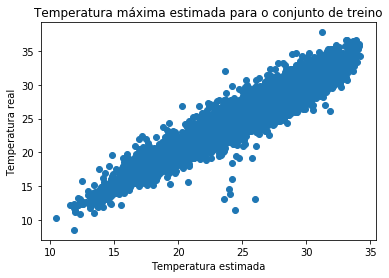

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.96085949]
 [0.96085949 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

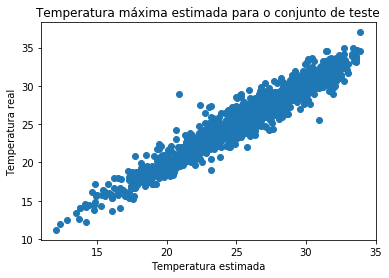

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.96363127]
 [0.96363127 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.92997723646243


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.4444645501995803


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,20.8,0.0,3.2,16.98,87.50,2.466667,17.7
1980-01-02,22.2,7.9,2.0,17.78,77.50,4.066667,0.0
1980-01-03,24.7,11.7,3.7,18.54,68.75,3.033333,0.0
1980-01-04,28.4,8.8,4.3,18.50,72.00,2.300000,0.0
1980-01-05,26.4,9.3,4.9,19.46,75.75,3.733333,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    14.9
1980-01-02    13.9
1980-01-03    14.2
1980-01-04    12.9
1980-01-05    14.6
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13253.000000,8118.000000,13293.000000,13220.000000,13272.000000,13322.000000,13324.000000
mean,0.179521,-0.160382,-0.666204,0.195316,0.311345,-0.383569,-0.942050
std,0.299853,0.569163,0.186354,0.311087,0.321009,0.245964,0.146593
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.023891,-0.714286,-0.800000,-0.015165,0.138790,-0.554656,-1.000000
50%,0.208191,-0.079365,-0.700000,0.220339,0.359431,-0.400810,-1.000000
75%,0.406143,0.333333,-0.572727,0.427297,0.537367,-0.222672,-0.971014
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13324, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 154.2252 - mean_absolute_error: 11.7489
Epoch 2/200
 - 1s - loss: 45.9437 - mean_absolute_error: 5.9815
Epoch 3/200
 - 1s - loss: 16.2752 - mean_absolute_error: 3.3544
Epoch 4/200
 - 1s - loss: 11.3006 - mean_absolute_error: 2.7859
Epoch 5/200
 - 1s - loss: 8.3232 - mean_absolute_error: 2.3428
Epoch 6/200
 - 1s - loss: 3.0915 - mean_absolute_error: 1.3772
Epoch 7/200
 - 1s - loss: 1.6307 - mean_absolute_error: 0.9766
Epoch 8/200
 - 1s - loss: 1.3375 - mean_absolute_error: 0.8750
Epoch 9/200
 - 1s - loss: 1.2231 - mean_absolute_error: 0.8315
Epoch 10/200
 - 1s - loss: 1.1408 - mean_absolute_error: 0.7972
Epoch 11/200
 - 1s - loss: 1.0988 - mean_absolute_error: 0.7802
Epoch 12/200
 - 1s - loss: 1.0562 - mean_absolute_error: 0.7649
Epoch 13/200
 - 1s - los

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.893474, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.893474 (0.059749) {'batch_size': 10, 'camadas': 2, 'units': 7}


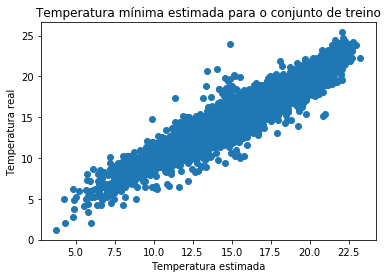

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.96162759]
 [0.96162759 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

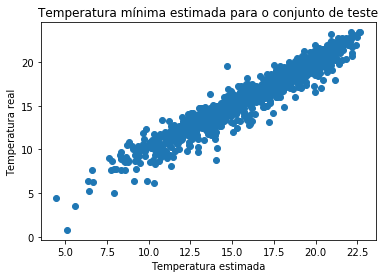

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.96279031]
 [0.96279031 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.6825126912660019


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.8681824336053415


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaSaoPaulo.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaSaoPaulo.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))